# Bike Sharing Analysis(Facebook Prophet)
Prophet equation:
y(t) = trend(t) + seasonality(t) + holidayOrEventImpact(t) + exogenousRegressors(t) + error

## Take a peek at data

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

def evaluate(train, test, pred, title):
    y_true = test
    y_pred = pred
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print("{} Errors: rmse = {}, mae = {}, mape = {}".format(title, rmse, mae, mape))

    plt.figure(figsize=(15, 7))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(pred, label=title)
    plt.legend()
    plt.show()

In [144]:
# Load
df = pd.read_csv('./data/Daily Bike Sharing training.csv')
df.rename(columns={'dteday': 'ds', 'cnt': 'y'}, inplace=True)

# parse date
df['ds'] = pd.to_datetime(df['ds'], format="%m/%d/%Y")

# process weather as categorical variables
weathersit = pd.get_dummies(df['weathersit'], drop_first=True)
df = pd.concat([df, weathersit], axis=1)
df.rename(columns={2: 'weathersit_2', 3: 'weathersit_3'}, inplace=True)
df.drop(['weathersit'], axis=1, inplace=True)

# drop unnecessary columns
df.drop(columns=['instant', 'season', 'yr', 'mnth', 'weekday', 'casual', 'registered'], inplace=True)

# Replace extreme value of 2012-10-29 when the hurricane Sandy hit
df.loc[df['ds'] == '2012-10-29', 'y'] = df.loc[df['ds'] == '2012-10-22', 'y'].values
df.loc[df['ds'] == '2012-10-30', 'y'] = df.loc[df['ds'] == '2012-10-23', 'y'].values

print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            701 non-null    datetime64[ns]
 1   holiday       701 non-null    int64         
 2   workingday    701 non-null    int64         
 3   temp          701 non-null    float64       
 4   atemp         701 non-null    float64       
 5   hum           701 non-null    float64       
 6   windspeed     701 non-null    float64       
 7   y             701 non-null    int64         
 8   weathersit_2  701 non-null    bool          
 9   weathersit_3  701 non-null    bool          
dtypes: bool(2), datetime64[ns](1), float64(4), int64(3)
memory usage: 45.3 KB
None


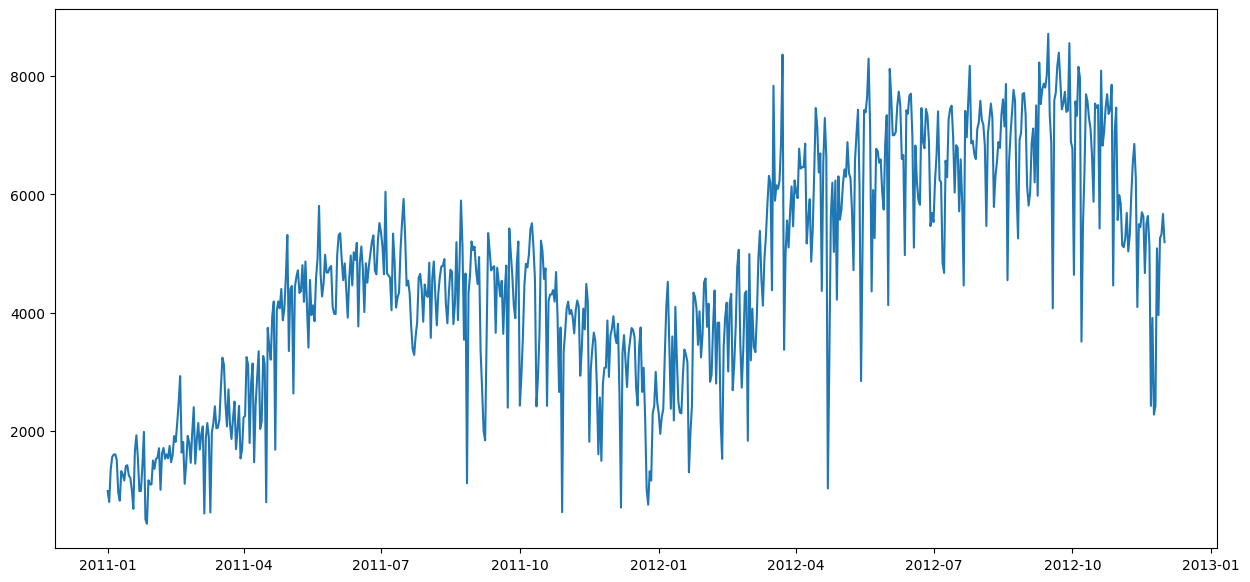

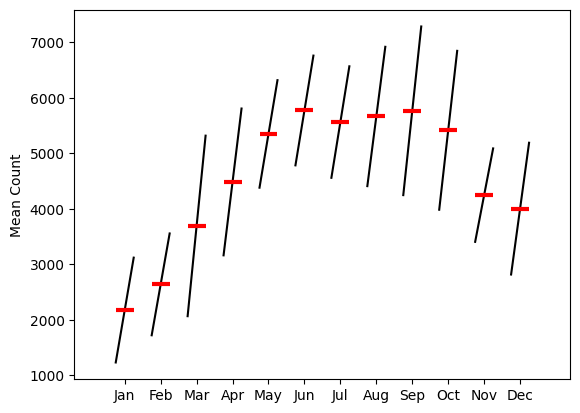

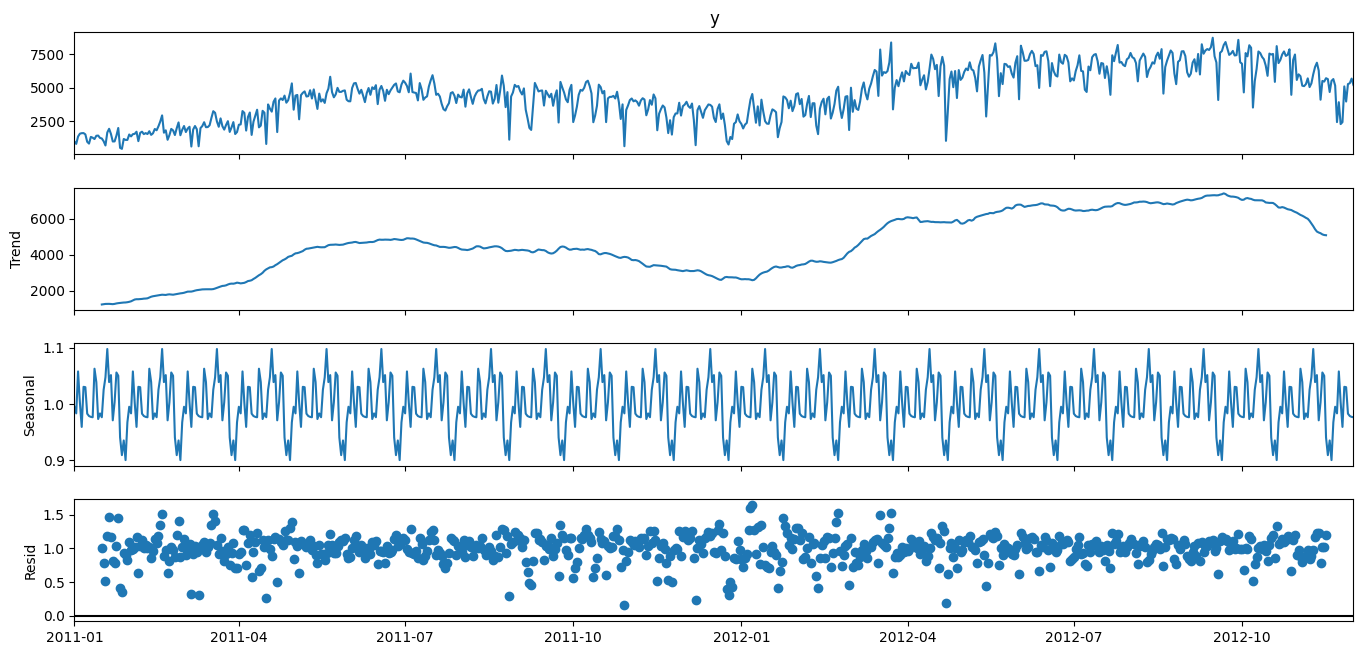

In [145]:
# Seasonality
df_copy = df.copy()

plt.figure(figsize=(15, 7))
plt.plot(df['ds'], df['y'])
plt.show()

df_copy.set_index('ds', inplace=True)
df_copy = df_copy.asfreq('D')
month_plot(df_copy['y'].resample('ME').mean(), ylabel='Mean Count')
plt.show()

decomposition = seasonal_decompose(df_copy['y'], model='mul', period=30)
fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()


In [146]:
# define holidays
holidayNormal = pd.DataFrame({
    'holiday':'normal', 'ds': df[df['holiday']==1]['ds'], 'lower window':-2, 'upper window':2
    })
xmas = pd.DataFrame({
    'holiday':'chrismas_eve', 'ds':pd.to_datetime(['2011-12-24', '2012-12-24']), 'lower window':-5, 'upper window':3
    })
nye = pd.DataFrame({
    'holiday':'new_years_eve', 'ds':pd.to_datetime(['2011-12-31', '2012-12-31']), 'lower window':-3, 'upper window':3
    })
holidays = pd.concat([holidayNormal, xmas, nye])
holidays


,holiday,ds,lower window,upper window
16,normal,2011-01-17,-2,2
51,normal,2011-02-21,-2,2
104,normal,2011-04-15,-2,2
149,normal,2011-05-30,-2,2
184,normal,2011-07-04,-2,2
247,normal,2011-09-05,-2,2
282,normal,2011-10-10,-2,2
314,normal,2011-11-11,-2,2
327,normal,2011-11-24,-2,2
359,normal,2011-12-26,-2,2


# Feature Engineering

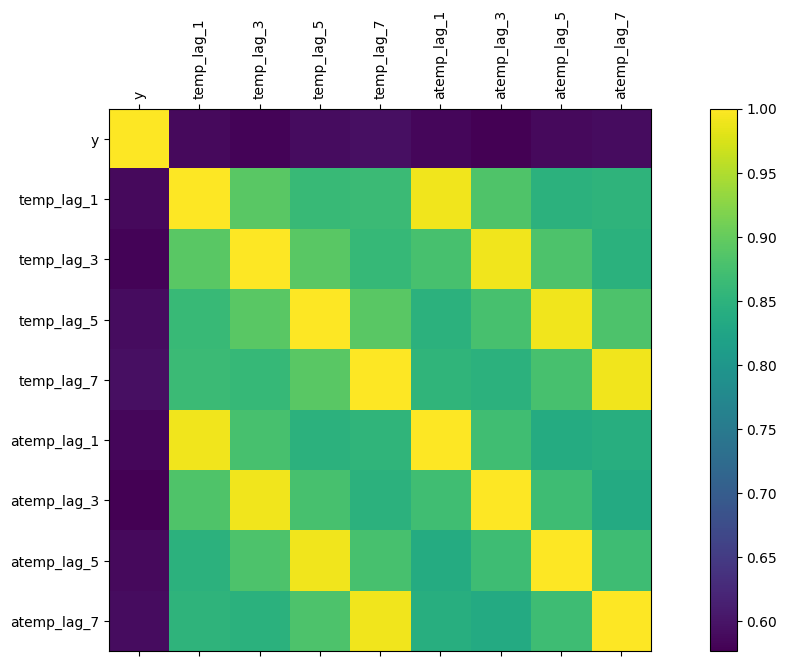

In [147]:
# create lagged features
for i in [1,3,5,7]:
    df[f'temp_lag_{i}'] = df['temp'].shift(i)
    df[f'atemp_lag_{i}'] = df['atemp'].shift(i)

# check coorelation
columns = ['y'] + [f'{var}_lag_{i}' for var in ['temp', 'atemp'] for i in [1,3,5,7]]
corr = df[columns].corr()
plt.figure(figsize=(15, 7))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

# remove other than temp_lag_1 and atemp_lag_1
df.drop(columns=[f'{var}_lag_{i}' for var in ['temp', 'atemp'] for i in [3,5,7]], inplace=True)

## Train Prophet model

In [148]:
df = df.dropna()

from prophet import Prophet

m = Prophet(
    seasonality_mode='multiplicative',
    holidays=holidays,
    seasonality_prior_scale=10, # strength of the seasonality
    holidays_prior_scale=10, # larger values will allow the model to fit more closely to the holidays
    changepoint_prior_scale=0.05 # does the trend change easily?
)
m.add_regressor('workingday')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.add_regressor('weathersit_2')
m.add_regressor('weathersit_3')
m.add_regressor('temp_lag_1')
m.add_regressor('atemp_lag_1')
m.fit(df)


18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing


In [149]:
# Regressor Coefficients
from prophet.utilities import regressor_coefficients
coef = regressor_coefficients(m)

# Function to interpret the coefficient results
def interpret_prophet_coefficients(df):
    interpretations = []

    # Iterate through each row in the DataFrame 'df'
    for _, row in df.iterrows():
        regressor = row['regressor']  # Get the regressor name
        mode = row['regressor_mode']  # Get the regressor mode (multiplicative or additive)
        coef = row['coef']  # Get the coefficient value
        effect_type = 'increase' if coef > 0 else 'decrease'  # Determine if the effect is an increase or decrease

        # Generate interpretation based on the regressor mode
        if mode == 'multiplicative':
            interpretation = f"For each unit increase in {regressor}, the target variable is expected to {effect_type} by {abs(coef) * 100:.2f}% (multiplicatively)."
        elif mode == 'additive':
            interpretation = f"For each unit increase in {regressor}, the target variable changes by {coef:.2f} units (additively)."
        else:
            interpretation = f"Regressor {regressor} has an unrecognized mode '{mode}'."

        interpretations.append(interpretation)

    return interpretations

coefs = pd.DataFrame(coef)  # Get regressor coefficients from the Prophet model
interpretations = interpret_prophet_coefficients(coefs) # Generate interpretations based on coefficients

# Print each interpretation
for interpretation in interpretations:
    print(interpretation)

For each unit increase in workingday, the target variable is expected to increase by 21.19% (multiplicatively).
For each unit increase in temp, the target variable is expected to increase by 72.08% (multiplicatively).
For each unit increase in atemp, the target variable is expected to increase by 81.83% (multiplicatively).
For each unit increase in hum, the target variable is expected to decrease by 30.80% (multiplicatively).
For each unit increase in windspeed, the target variable is expected to decrease by 37.86% (multiplicatively).
For each unit increase in weathersit_2, the target variable is expected to decrease by 8.15% (multiplicatively).
For each unit increase in weathersit_3, the target variable is expected to decrease by 38.29% (multiplicatively).
For each unit increase in temp_lag_1, the target variable is expected to decrease by 49.94% (multiplicatively).
For each unit increase in atemp_lag_1, the target variable is expected to increase by 20.01% (multiplicatively).


## Cross Validation

In [150]:
from prophet.diagnostics import cross_validation
# initial: 701 total - 180 test = 521 train
df_cv = cross_validation(model=m, period='15 days',initial='521 days', horizon='30 days', parallel="processes")



Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
18:54:50 - cmdstanpy -

In [151]:
print(len(df_cv))
df_cv
# cutoff = the cutoff date for the test set
# yhat = the predicted value
# y = the true value
# yhat_lower = the lower bound of the predicted value
# yhat_upper = the upper bound of the predicted value

300


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8713.903814,7863.018369,9594.114746,6211,2012-06-19
1,2012-06-21,9060.503339,8206.902300,9902.507863,5905,2012-06-19
2,2012-06-22,8619.532758,7794.704759,9491.126123,5823,2012-06-19
3,2012-06-23,8217.176969,7429.349255,9081.553721,7458,2012-06-19
4,2012-06-24,8227.428924,7461.375510,9064.268909,6891,2012-06-19
...,...,...,...,...,...,...
295,2012-11-27,5871.509511,4976.052026,6784.613401,3959,2012-11-01
296,2012-11-28,7206.504791,6253.644209,8095.715917,5260,2012-11-01
297,2012-11-29,7547.335785,6749.087105,8509.326995,5323,2012-11-01
298,2012-11-30,7831.520172,6951.492849,8723.580804,5668,2012-11-01


  horizon           mse         rmse          mae      mape     mdape  \
0  3 days  2.165864e+06  1471.687628  1187.201237  0.207140  0.145410   
1  4 days  2.146759e+06  1465.182101  1138.070506  0.195600  0.109525   
2  5 days  1.869270e+06  1367.212459  1081.590683  0.183561  0.101145   
3  6 days  1.241972e+06  1114.437911   918.177708  0.148862  0.102131   
4  7 days  1.066669e+06  1032.796520   829.212636  0.128910  0.091018   

      smape  coverage  
0  0.185161  0.500000  
1  0.174219  0.566667  
2  0.163529  0.566667  
3  0.139488  0.600000  
4  0.125570  0.633333  
Mean RMSE: 1445.907549705329
Mean MPAE: 0.19183622582284174
Mean MAE: 1121.8831939035751


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


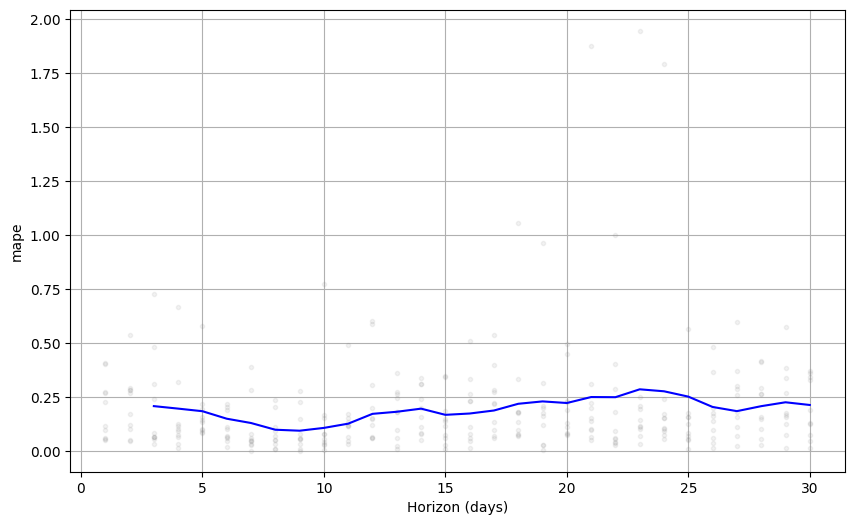

In [152]:
# Apply Performance Metrics
from prophet.diagnostics import performance_metrics
performance = performance_metrics(df_cv)
print(performance.head())
print(f'Mean RMSE: {performance["rmse"].mean()}')
print(f'Mean MPAE: {performance["mape"].mean()}')
print(f'Mean MAE: {performance["mae"].mean()}')
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

# Parameter Tuning

In [153]:
param_grid = {
    'changpoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1, 10, 20],
    'holidays_prior_scale': [1, 10, 20],
    'seasonality_mode': ['multiplicative', 'additive'],
}

grid = ParameterGrid(param_grid)
all_params = list(grid)
total_params = len(all_params)
print(f'all params: {total_params}')


all params: 54


In [ ]:
def train_model(params):
    m = Prophet(
        seasonality_mode=params['seasonality_mode'],
        holidays=holidays,
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        changepoint_prior_scale=params['changpoint_prior_scale']
    )
    m.add_regressor('workingday')
    m.add_regressor('temp')
    m.add_regressor('atemp')
    m.add_regressor('hum')
    m.add_regressor('windspeed')
    m.add_regressor('weathersit_2')
    m.add_regressor('weathersit_3')
    m.add_regressor('temp_lag_1')
    m.add_regressor('atemp_lag_1')
    m.fit(df)
    return m

best_rmse = float('inf')
best_params = None

results = []

for index, params in enumerate(all_params):
    print(f'({index+1}/{total_params})testing params: {params}')
    m = train_model(params)
    df_cv = cross_validation(model=m, period='15 days', initial='521 days', horizon='30 days', parallel="processes")
    performance = performance_metrics(df_cv)
    mean_rmse = performance['rmse'].mean()
    results.append(mean_rmse)
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params
    print(f'params: {params}, rmse: {mean_rmse}')

In [163]:
outcome = pd.DataFrame(all_params)
outcome['tuning_results'] = results
print(outcome.loc[outcome['tuning_results'].idxmin()])
# print(best_params)


changpoint_prior_scale            0.01
holidays_prior_scale                 1
seasonality_mode              additive
seasonality_prior_scale             20
tuning_results             1087.060116
Name: 5, dtype: object


In [156]:
best_m = train_model(best_params)

18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:31 - cmdstanpy - INFO - Chain [1] done processing
